## Assignment - Syntactic Analysis

## Problem Statement


### Issue with HMMs and Viterbi algorithm for POS tagging

The vanilla Viterbi algorithm had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. **This is because, for unknown words, the emission probabilities for all candidate tags are 0**, so the algorithm arbitrarily chooses (the first) tag.

#### Following approaches are used to solve the above problem:
- Most Frequent tag in the training set
- Based on Morphological cues
- Ignore emission probability incase of unknown words
- Laplace smoothing for unknown words

### Data Description

Treebank dataset is tagged with following 12 tags :
1. **VERB** - verbs (all tenses and modes)
2. **NOUN** - nouns (common and proper)
3. **PRON** - pronouns 
4. **ADJ** - adjectives
5. **ADV** - adverbs
6. **ADP** - adpositions (prepositions and postpositions)
7. **CONJ** - conjunctions
8. **DET** - determiners
9. **NUM** - cardinal numbers
10. **PRT** - particles or other function words
11. **X** - other: foreign words, typos, abbreviations
12. **.** - punctuation

### Data Preparation

In [219]:
#Importing libraries
import nltk
import random
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
from collections import Counter

In [220]:
# Download the universal tag set
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\mouni\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [221]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [222]:
len(nltk_data) 

3914

Data has 3914 sentences.

In [223]:
# checking the data of first sentence
nltk_data[0]

[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('board', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('nonexecutive', 'ADJ'),
 ('director', 'NOUN'),
 ('Nov.', 'NOUN'),
 ('29', 'NUM'),
 ('.', '.')]

In [224]:
#Splitting the data into train and test set
random.seed(1234)
train_set,test_set= train_test_split(nltk_data,test_size=0.05,random_state=10)

In [225]:
len(train_set)

3718

In [226]:
len(test_set)

196

In [227]:
# Combining all the words in sentences of train set 
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95440

In [228]:
# get all the words of train set
tokens = [pair[0] for pair in train_tagged_words]

In [229]:
# Get all unique words of train data to generate the vocabulary
V = set(tokens)
print(len(V))

12007


In [230]:
# get all unique tags present in train data
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [231]:
print(T)

{'ADV', '.', 'X', 'CONJ', 'NUM', 'ADJ', 'NOUN', 'ADP', 'DET', 'VERB', 'PRT', 'PRON'}


#### HMMs and Viterbi algorithm for POS tagging

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

**Emission probability :** The probability of occurance of word given the tag.<br>
> P(w/t) = count(w, t) / count(t) where count(w,t) refers to number of times word and tag appeared together in train dataset.

**Transition Probability:** Probability of tag given the previous tag
 The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1).

### Emission Probabilities

#### Create three helper dictionaries which can help to reduce the computation time
- tag_and_words : Dictionary which has tag as key and list of words as value
- tag_counters : Dictionary which stores the tag as key and counter object of words in value
- tag_counts : Dictionary which stores the tag as key and count of the words having the tag in value

In [232]:
tag_and_words={}
tag_counters={}
tag_counts={}
for tag in T:
    words=[pair[0] for pair in train_tagged_words if pair[1]==tag] # Get all the words for the tag
    tag_and_words[tag]=words  # we will be storing  all the words in dictionary for tag in tag_and_words dictionary 
    tag_counters[tag]=Counter(words) # save the counter object for the words in tag_counters
    tag_counts[tag]=len(words) # save the length of words in tag_counts dictionary against tag

In [233]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words): 
    count_tag = tag_counts[tag]  # get number of words having the tag from tag_counts dictionary
    count=tag_counters[tag].get(word) # get the count of word from the counter 
    if count!=None: # Counter returns none if the word is not available in the train set.
        count_w_given_tag = count
    else:
        count_w_given_tag=0  # AS the word is not available for that tag, we return 0  
    return (count_w_given_tag, count_tag)

### Transition Probabilities

**t2_given_t1** method computes the probability of t2 tag given that previous tag was t1

In [234]:
def t2_given_t1(t2, t1,tags): 
    count_t1 = tag_counts[t1] # get the count from precomputed tag_counts dictionary
    count_t2_t1 = 0
    for index in range(len(tags)-1): #loop over each tag in training set,check if the current tag is t1 and next tag is t2 
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1   # increment the count
    return (count_t2_t1,count_t1)

In [235]:
tags_matrix = np.zeros((len(T), len(T)), dtype='float32') #create 12*12 matrix
tags = [pair[1] for pair in train_tagged_words] # get list of tags in training set
for i, t1 in enumerate(list(T)): # for every tag compute the count of tag followed and store it in tags_matrix
    for j, t2 in enumerate(list(T)): 
        count_t2_t1, count_t1=t2_given_t1(t2, t1,tags) 
        tags_matrix[i, j] = count_t2_t1/count_t1

In [236]:
# create dataframe and check the results
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T)) 

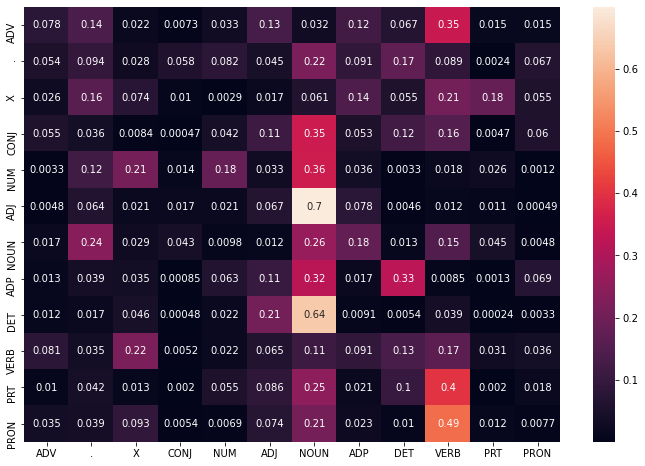

In [237]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(12, 8))
sns.heatmap(tags_df,annot=True)
plt.show()

**Patterns seen:**
- Probability of DET or ADJ followed by NOUN is high
- PRONOUN is mostly followed by verb or noun
- PRT is mostly followed by verb
- Adverb is mostly followed by verb
- conj is mostly followed by NOUN
- Noun mostly follows either Noun or .

###  Viterbi based POS tagger with modifications

#### Intution for viterbi modification with most frequent tag for unkown words
 > 1. For every word ,loop over all the tags and calcualte probabilities.
 > 2. Get the maximum of these probabilites , if the max value is zero . That means word is unknown to the dataset
 > 3. Use the getFrequentToken method and get the most frequent tag and use it for all unknown words

In [238]:
def getFrequentToken(train_bag):
    tags=[tup[1] for tup in train_bag] # get all tags of training set
    tags_count=Counter(tags).most_common() # returns the list of tuple with tag and their counts in descending order
    tag= tags_count[0][0] # select the first tuple and select the tag from it    
    return tag

#### Intution for viterbi modification with rule based tagging for unkown words
 > 1. For every word ,loop over all the tags and calcualte probabilities.
 > 2. Get the maximum of these probabilites , if the max value is zero . That means word is unknown to the dataset
 > 3. For every unknown word, call the getRuleBasedTagger method and get the tag

In [239]:
patterns = [
    (r'.*(ing|ed)$', 'VERB'),              # words ending with ing or ed or es would be considered as verb
    (r'.*(ly|ward|wise)s?$', 'ADV'),          # words ending with ly or ward or wise would be considered as adverbs
    (r'^[0-9]+(.[0-9]+)?$', 'NUM'), # words with number would be considered as NUM
    (r'.*\*.*-?.*','X'), # words with - and * would be considered as X
    (r'.*-?.*(ous|ful|able|al|less|ive|ish)$','ADJ'),#words ending with ous|ful|able|al|less|ive|ish would be adjectives
    (r'.*', 'NOUN')                    # remaining would be considered as nouns
]
regexp_tagger = nltk.RegexpTagger(patterns)
def getRuleBasedTagger(word):
    l=[word]
    tag=regexp_tagger.tag(l)[0][1]
    return tag    

#### Intution for viterbi modification with no emission probabilites for unkown words
 > 1. For every word ,loop over all the tags and store state_probability as well as  transition probability.
 > 2. Get the maximum of state probabilites , if the max value is zero . That means word is unknown to the training dataset.
 > 3. For every unknown word, get the maximum of transition probability and get the tag which has maximum transition probability

#### Intution for viterbi modification with laplace smoothing for unkown words
Emission probability  is calculated as count_of_word_given_tag/count_of_tag
 > - In case of unknown words, emission probability would be zero.
 > - In case of known word but with unknown tag , emission probability would be zero.<br>
 **Laplace smoothing** is used to make emission probability non-zero for all unknown cases. 
 so , we use the following formula for getting emission probability :
>>emission_p = (count_w_given_tag+1)/(count_tag+v) <br>
>> we increment each word count by 1 , so for unknown words or known words with unknown tags , count would be 1 <br>
>> We increment the count of tags by the size of vocabulary(len of unique words both in test set and train set) , since we are incrementing the count by 1 for both known words and unknown words 

In [240]:
def Viterbi(sents,modification="none" ,train_bag = train_tagged_words):
    cache_emission_prob={}
    state = []
    T = list(set([pair[1] for pair in train_bag])) # get all tags
    train_words=[tup[0] for tup in train_tagged_words]  # get all words present in train set
    test_words=[item for sublist in sents for item in sublist] # get all words of test set
    train_words.extend(test_words) # concatenate both the lists
    v=len(set(train_words)) # get the length of unique words both in test and train set
    most_common_tag=None
    words=[]
    for key, sent in enumerate(sents):
        #initialise list of probability column for a given observation
        for word in sent:
            words.append(word)
            p = [] # list which stores  the probability for each tag for given word
            transition_p_lis=[]
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag] # getting the transition probability of the starting tag
                else:
                    transition_p = tags_df.loc[state[-1], tag]  # getting the transition probability of the non starting tag
                
                # compute emission and state probabilities
                if cache_emission_prob.get((word, tag))==None: # check if word has been traversed earlier or not
                    count_w_given_tag, count_tag=word_given_tag(word, tag) # as it is new words, get the emission probability
                    if modification=='laplace':
                        emission_p = (count_w_given_tag+1)/(count_tag+v)
                    else:
                        emission_p = count_w_given_tag/count_tag
                    
                    cache_emission_prob[(word,tag)]=emission_p # store in the dictionary
                else:
                    emission_p=cache_emission_prob.get((word, tag)) # word has been parsed earlier, so get the emission prob from dict
                state_probability = emission_p * transition_p   # calculate state probability 
                p.append(state_probability)
                transition_p_lis.append(transition_p)
                
            pmax = max(p) # get maximum probability
            state_max = T[p.index(pmax)] # get the tag which has maximum probability
            if pmax==0 :  # if pmax is zero then word in unknown for training corpus         
                if modification=='most_common_tag':
                    if most_common_tag==None:
                        state_max=getFrequentToken(train_bag) 
                        most_common_tag=state_max
                    else:
                        state_max=most_common_tag
                elif modification=='rule_based':
                    state_max=getRuleBasedTagger(word)
                elif modification=='no_emission':
                    transition_max=max(transition_p_lis)
                    state_max = T[transition_p_lis.index(transition_max)]
            state.append(state_max) # associate the tag with word
    return list(zip(words, state))

In [241]:
len(test_set)

196

In [242]:
# get list of sentences from test_set
test_tagged_words=[]
for sent in test_set:
    l=[]
    for tup in sent:
        l.append(tup[0])
    test_tagged_words.append(l)

In [243]:
test=[words for words in test_tagged_words]
len(test)
t= [item for sublist in test for item in sublist]
print(len(t))

5236


In [244]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [245]:
print("Time taken to run the algorithm is {} seconds".format(difference))

Time taken to run the algorithm is 1.7163927555084229 seconds


In [246]:
test_run_base = [tup for sent in test_set for tup in sent]

In [247]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [248]:
len(check)

4690

In [249]:
accuracy = len(check)/len(test_run_base)

In [250]:
accuracy*100

89.57219251336899

In [251]:
incorrect_tagged_vanilla_viterbi = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [252]:
len(incorrect_tagged_vanilla_viterbi)

546

#### Evaluating tagging accuracy of modified algorithms

In [253]:
# tagging the test sentences based on most common tag for unknown words
start = time.time()
tagged_seq = Viterbi(test_tagged_words,modification ='most_common_tag')
end = time.time()
difference = end-start

In [254]:
print("Time taken to run the algorithm is {} seconds".format(difference))

Time taken to run the algorithm is 1.643019437789917 seconds


In [255]:
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [256]:
accuracy = len(check)/len(test_run_base)
accuracy

0.9407944996180291

In [257]:
incorrect_tagged_most_common = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [258]:
# tagging the test sentences based on morphological rules for unknown words
start = time.time()
tagged_seq = Viterbi(test_tagged_words,modification ='rule_based')
end = time.time()
difference = end-start

In [259]:
print("Time taken to run the algorithm is {} seconds".format(difference))

Time taken to run the algorithm is 1.7902145385742188 seconds


In [260]:
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [261]:
accuracy = len(check)/len(test_run_base)
accuracy

0.9589381207028266

In [262]:
incorrect_tagged_rule_based = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [263]:
# tagging the test sentences based on laplace smoothing for unknown words
start = time.time()
tagged_seq = Viterbi(test_tagged_words,modification ='laplace')
end = time.time()
difference = end-start

In [264]:
print("Time taken to run the algorithm is {} seconds".format(difference))

Time taken to run the algorithm is 1.76289701461792 seconds


In [265]:
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [266]:
accuracy = len(check)/len(test_run_base)
accuracy

0.8896103896103896

In [267]:
incorrect_tagged_laplace= [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [268]:
# tagging the test sentences based on laplace smoothing for unknown words
start = time.time()
tagged_seq = Viterbi(test_tagged_words,modification ='no_emission')
end = time.time()
difference = end-start

In [269]:
print("Time taken to run the algorithm is {} seconds".format(difference))

Time taken to run the algorithm is 1.8651258945465088 seconds


In [270]:
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [271]:
accuracy = len(check)/len(test_run_base)
accuracy

0.9400305576776165

In [272]:
incorrect_tagged_probabilistic= [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

- Accuracy of vanilla viterbi algorithm is 90%
- Accuracy of viterbi algorithm with most frequent tag for unknown words is 94.07%
- Accuracy of viterbi algorithm with morphological cues for unknown words is **95.98%**
- Accuracy of viterbi algorithm without considering emission probability for unknown words is 94%
- Accuracy of viterbi algorithm wit laplace smoothing for unknown words is 88.96%

**Reason for laplace smoothing to be underperforming :**
> We are assigning  non-zero probability for unknown words as well as word with unknown tags.
> As the vocab size is too large , it will create sparse matrix with rows as vocabulary and tags as columns . Since we are have to fill all the cells of matrix , it would reduce the weights of orginal tags to make it balanced with others. Hence Laplace smoothing is not right approach for this usecase.

### POS tagging for test sentences

In [273]:
test_df= pd.read_csv('Test_sentences.txt',sep='\t',header=None,names=["sentences"])

In [274]:
test_df

,sentences
0,Android is a mobile operating system developed...
1,Android has been the best-selling OS worldwide...
2,Google and Twitter made a deal in 2015 that ga...
3,Twitter is an online news and social networkin...
4,"Before entering politics, Donald Trump was a d..."
5,The 2018 FIFA World Cup is the 21st FIFA World...
6,This is the first World Cup to be held in East...
7,Show me the cheapest round trips from Dallas t...
8,I would like to see flights from Denver to Phi...
9,Show me the price of the flights leaving Atlan...


In [276]:
from nltk.tokenize import word_tokenize

In [277]:
test_words=test_df.sentences.apply(lambda x : word_tokenize(x))

In [278]:
test_words

0     [Android, is, a, mobile, operating, system, de...
1     [Android, has, been, the, best-selling, OS, wo...
2     [Google, and, Twitter, made, a, deal, in, 2015...
3     [Twitter, is, an, online, news, and, social, n...
4     [Before, entering, politics, ,, Donald, Trump,...
5     [The, 2018, FIFA, World, Cup, is, the, 21st, F...
6     [This, is, the, first, World, Cup, to, be, hel...
7     [Show, me, the, cheapest, round, trips, from, ...
8     [I, would, like, to, see, flights, from, Denve...
9     [Show, me, the, price, of, the, flights, leavi...
10    [NASA, invited, social, media, users, to, expe...
Name: sentences, dtype: object

In [279]:
tagged_seq_vanilla_viterbi = Viterbi(test_words)

In [280]:
df1 = pd.DataFrame(tagged_seq_vanilla_viterbi, columns =['word', 'tag_vanilla_viterbi']) 

In [281]:
tagged_seq_most_common_tag = Viterbi(test_words,modification ='most_common_tag')

In [282]:
df2=pd.DataFrame(tagged_seq_most_common_tag, columns =['word', 'tag_most_common'])

In [283]:
tagged_seq_rule_based = Viterbi(test_words,modification ='rule_based')

In [284]:
df3=pd.DataFrame(tagged_seq_rule_based, columns =['word', 'tag_rule_based'])

In [285]:
tagged_seq_laplace = Viterbi(test_words,modification ='laplace')

In [286]:
df4=pd.DataFrame(tagged_seq_laplace, columns =['word', 'tag_laplace'])

In [287]:
tagged_seq_no_emission = Viterbi(test_words,modification ='no_emission')

In [288]:
df5=pd.DataFrame(tagged_seq_no_emission, columns =['word', 'tag_no_emission'])

In [289]:
test_tags_df=pd.concat([df1.set_index('word'),df2.set_index('word'),df3.set_index('word'),df4.set_index('word'),df5.set_index('word')], axis=1, join='inner').reset_index()

In [290]:
test_tags_df

,word,tag_vanilla_viterbi,tag_most_common,tag_rule_based,tag_laplace,tag_no_emission
0,Android,ADV,NOUN,NOUN,DET,NOUN
1,is,VERB,VERB,VERB,VERB,VERB
2,a,DET,DET,DET,DET,DET
3,mobile,ADJ,ADJ,ADJ,DET,ADJ
4,operating,NOUN,NOUN,NOUN,NOUN,NOUN
...,...,...,...,...,...,...
176,launch,NOUN,NOUN,NOUN,NOUN,NOUN
177,of,ADP,ADP,ADP,ADP,ADP
178,ICESAT-2,ADV,NOUN,NOUN,DET,DET
179,Satellite,ADV,NOUN,NOUN,NOUN,NOUN


In [291]:
test_tags_df[~(test_tags_df.tag_vanilla_viterbi==test_tags_df.tag_most_common)]

,word,tag_vanilla_viterbi,tag_most_common,tag_rule_based,tag_laplace,tag_no_emission
0,Android,ADV,NOUN,NOUN,DET,NOUN
8,Google,ADV,NOUN,NOUN,DET,NOUN
10,Android,ADV,NOUN,NOUN,DET,NOUN
15,OS,ADV,NOUN,NOUN,NOUN,NOUN
16,worldwide,ADV,NOUN,NOUN,.,NOUN
18,smartphones,ADV,NOUN,NOUN,DET,DET
20,2011,ADV,NOUN,NUM,DET,DET
25,2013,ADV,NOUN,NUM,DET,DET
27,Google,ADV,NOUN,NOUN,DET,NOUN
29,Twitter,ADV,NOUN,NOUN,NOUN,NOUN


In [292]:
test_tags_df[~(test_tags_df.tag_vanilla_viterbi==test_tags_df.tag_rule_based)]

,word,tag_vanilla_viterbi,tag_most_common,tag_rule_based,tag_laplace,tag_no_emission
0,Android,ADV,NOUN,NOUN,DET,NOUN
8,Google,ADV,NOUN,NOUN,DET,NOUN
10,Android,ADV,NOUN,NOUN,DET,NOUN
15,OS,ADV,NOUN,NOUN,NOUN,NOUN
16,worldwide,ADV,NOUN,NOUN,.,NOUN
18,smartphones,ADV,NOUN,NOUN,DET,DET
20,2011,ADV,NOUN,NUM,DET,DET
25,2013,ADV,NOUN,NUM,DET,DET
27,Google,ADV,NOUN,NOUN,DET,NOUN
29,Twitter,ADV,NOUN,NOUN,NOUN,NOUN


In [293]:
len(test_tags_df[~(test_tags_df.tag_vanilla_viterbi==test_tags_df.tag_rule_based)])

38

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

1. Android,Google,Twitter,NASA,Satellite are tagged correctly as Nouns using most common /morphological cues
2. contested,invited,arriving are tagged correctly as verb using morphological cues
3. 2011,2015,2018,2013 are tagged correctly as NUM using morphological cues 